# Homogenous object detection tools

This tutorial teaches users how to use the tools provided by XCAL to obtain masks of homogeneous objects from a reconstruction.

**User Input**: A 2D reconstruction
**Expected Output**: A list of masks of homogeneous objects

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Prepare Input Reconstruction

### A. Simulated Spectrum

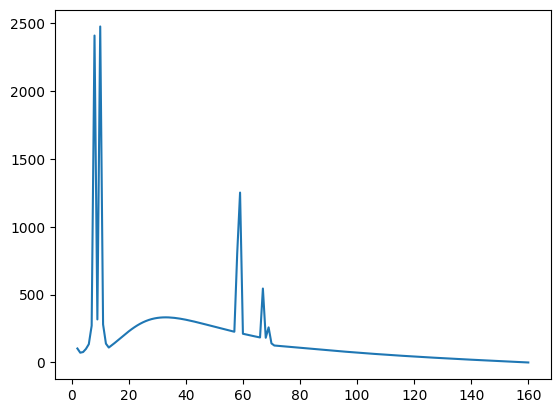

In [2]:
import spekpy as sp
psize = 0.05
s = sp.Spek(kvp=160, th=11, dk=1, mas=1, char=True,shift=0.5)  # Create the spectrum model
energies, src_spec = s.get_spectrum(edges=False)  # Get arrays of energy & fluence spectrum
src_spec = src_spec * ((psize / 10) ** 2)
norm_src_spec = src_spec / np.trapz(src_spec, energies, axis=0)
plt.plot(energies, src_spec)

### B. Simulated sinogram data

14.064771997051482
6.872537809547058
11.057861215250197
3.7245905076788834
0.7264523848025635


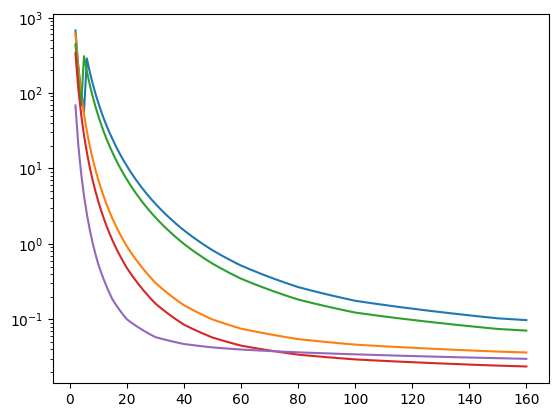

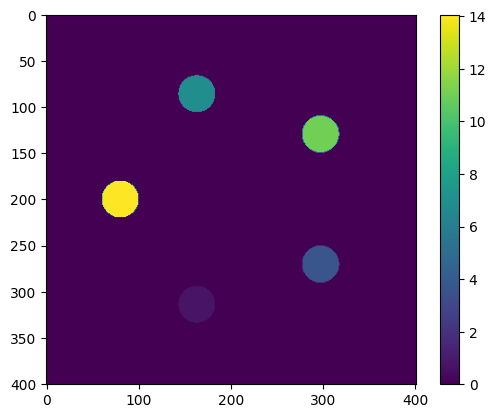

In [3]:
from xcal.phantom import generate_circle_masks
from xcal.chem_consts import get_lin_att_c_vs_E
from xcal.chem_consts._periodictabledata import density
from xcal import calc_forward_matrix

# Get masks list
cylinder_masks = generate_circle_masks(20, psize, 5, 6, 1)
cylinder_masks = [mask[np.newaxis] for mask in cylinder_masks]

# Get LAC
materials = ['V', 'Al', 'Ti', 'Mg', 'C']
mat_density = [density['%s' % formula] for formula in materials]
lac_vs_E_list = []
a = np.zeros(cylinder_masks[0].shape)
for i in range(len(materials)):
    formula = materials[i]
    den = mat_density[i]
    lac_vs_E = get_lin_att_c_vs_E(den, formula, energies)
    lac_vs_E_list.append(lac_vs_E)
    plt.plot(energies, lac_vs_E)
    print(np.mean(lac_vs_E))
    a += cylinder_masks[i]*np.mean(lac_vs_E)
plt.yscale('log')
plt.figure(2)
plt.imshow(a[0])
plt.colorbar()

In [4]:
# Get forward projector.
import svmbir

class fw_projector:
    """A class for forward projection using SVMBIR."""

    def __init__(self, angles, num_channels, delta_pixel=1):
        """
        Initializes the forward projector with specified geometric parameters.

        Parameters:
            angles (array): Array of projection angles.
            num_channels (int): Number of detector channels.
            delta_pixel (float, optional): Size of a pixel, defaults to 1.
        """
        self.angles = angles
        self.num_channels = num_channels
        self.delta_pixel = delta_pixel

    def forward(self, mask):
        """
        Computes the projection of a given mask.

        Parameters:
            mask (numpy.ndarray): 3D mask of the object to be projected.

        Returns:
            numpy.ndarray: The computed projection of the mask.
        """
        projections = svmbir.project(mask, self.angles, self.num_channels) * self.delta_pixel
        return projections
    
angles = np.linspace(-np.pi/2, np.pi/2, 200, endpoint=False)
projector = fw_projector(angles, num_channels=cylinder_masks[0].shape[-1], delta_pixel=psize)

# Calculate forward matrix
spec_F = calc_forward_matrix(cylinder_masks, lac_vs_E_list, projector)

# Calculate sinogram
trans = np.trapz(spec_F*norm_src_spec, energies, axis=-1)
sino = np.clip(-np.log(trans),0, np.inf)

Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/b9668769934402c85a78.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/b9668769934402c85a78.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/b9668769934402c85a78.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/b9668769934402c85a78.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/b9668769934402c85a78.2Dsvmatrix


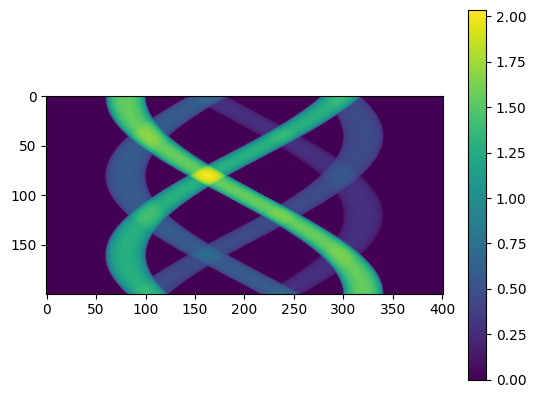

In [5]:
plt.imshow(sino[:,0])
plt.colorbar()

### C. SVMBIR Reconstruction

Calling multires_recon for axial size (rows,cols)=(201,201).
Calling multires_recon for axial size (rows,cols)=(101,101).
Reconstructing axial size (rows,cols)=(101,101).
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/70f2818343b94bc1c703.2Dsvmatrix
Reconstructing axial size (rows,cols)=(201,201).
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/848201f493a6bbf9ac67.2Dsvmatrix
Reconstructing axial size (rows,cols)=(401,401).
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/b9668769934402c85a78.2Dsvmatrix


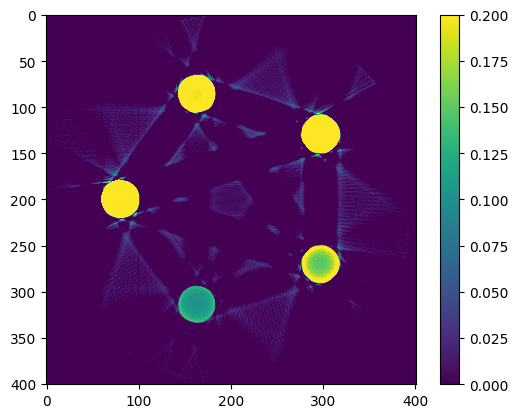

In [6]:
tilt_angle = np.pi/2 # Tilt range of +-90deg

# Reconstruction parameters
snr_db = 40.0
sharpness = 1.0
T = 0.1

# Determine resulting number of views, slices, and channels
(num_views, num_slices, num_channels) = sino.shape

# Perform fixed resolution MBIR reconstruction
recons = svmbir.recon(sino, angles, sharpness=sharpness, snr_db=snr_db, T=T)
plt.imshow(recons[0]/psize,vmin=0.0, vmax=0.2)
plt.colorbar()

## Output: Masks of Homogenous objects

In [7]:
from xcal.phantom import detect_hough_circles, segment_object

### A.Circle Detection

In [8]:
help(detect_hough_circles)

Help on function detect_hough_circles in module xcal.phantom:

detect_hough_circles(phantom, radius_range=None, vmin=0, vmax=None, min_dist=100, HoughCircles_params1=300, HoughCircles_params2=1)
    Detects circles in an image using the Hough Circle Transform.
    
    Args:
        phantom (numpy.ndarray): The 2D image to detect circles in.
        radius_range (list of int, optional): The minimum and maximum radius of
            circles to detect. Defaults to a range based on the image size.
        vmin (int, optional): Minimum value for clipping the image before
            detection. Defaults to 0.
        vmax (int, optional): Maximum value for clipping the image before
            detection. If None, the 90th percentile of the image is used.
            Defaults to None.
        min_dist (int, optional): Minimum distance between the centers of the
            detected circles. If too small, multiple neighbor circles may be
            falsely detected in addition to a true one.

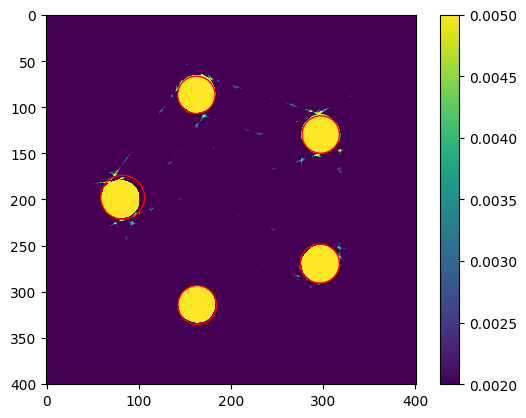

In [9]:
from matplotlib.patches import Circle
import math

plt.imshow(recons[0], vmin=0.002, vmax=0.005)
plt.colorbar()
# Get the current axes.
ax = plt.gca()
circles = detect_hough_circles(recons[0], radius_range=(20, 30), vmin=0.002, vmax=0.005, min_dist=100)
circles = sorted(circles, key=lambda x: math.atan2(x[1]-200.5, x[0]-200.5))
# Create and add circles to the plot.
for x, y, radius in circles:
    circle = Circle((x, y), radius, color='red', fill=False)
    ax.add_patch(circle)

# Optionally set the aspect of the plot to be equal.
# This makes sure that the circles are not skewed.
ax.set_aspect('equal')

# Show the plot with the circles.
plt.show()

### B.Segmentation of homogenous objects

In [10]:
help(segment_object)

Help on function segment_object in module xcal.phantom:

segment_object(phantom, vmin, vmax, canny_sigma, roi_radius=None, bbox=None)
    Segments an object within a given region of interest (ROI) or bounding box in an image.
    
    This function creates a segmentation mask for an object in an image. The image values
    are clipped and normalized based on provided minimum and maximum values. Canny edge
    detection is then applied to the normalized image. The edges are filled to create a
    binary mask that segments the object.
    
    Args:
        phantom (np.array): The input image to segment.
        vmin (float): The minimum value for clipping the image.
        vmax (float): The maximum value for clipping the image.
        canny_sigma (float): The standard deviation for the Gaussian filter used in
                             Canny edge detection.
        roi_radius (int, optional): The radius of the circular region of interest. If not
                                    p

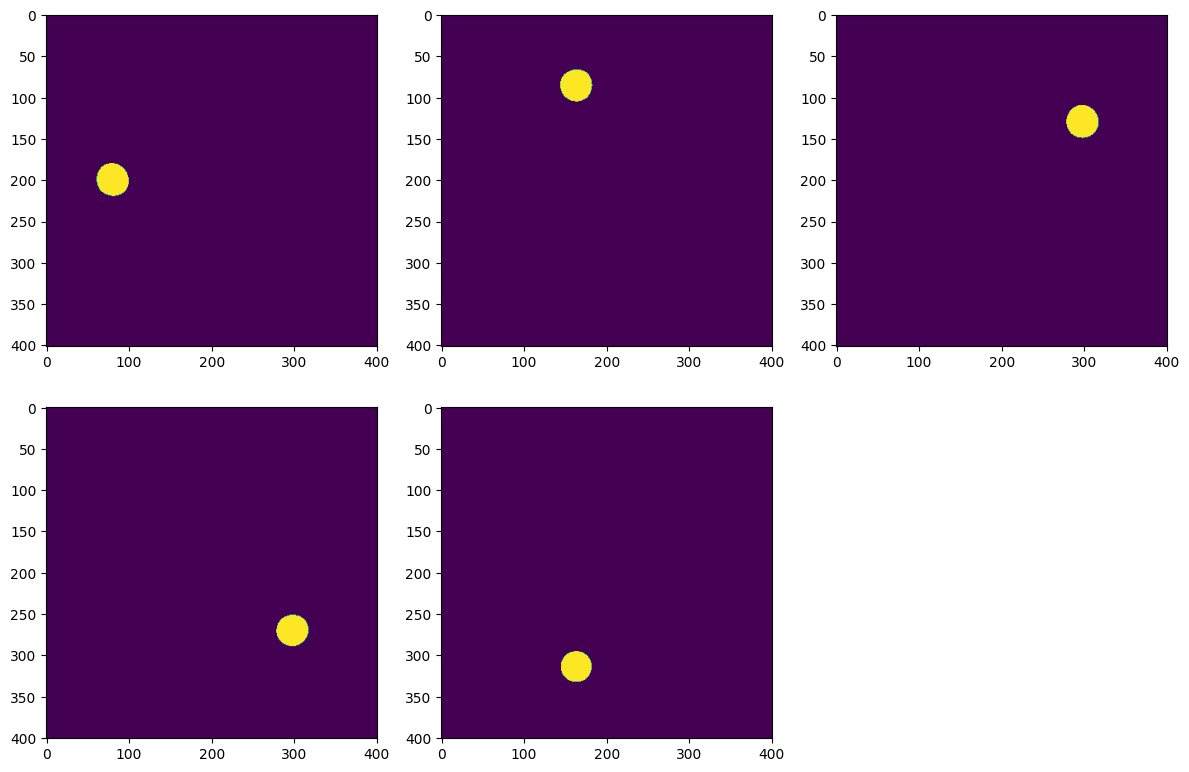

In [11]:
est_mask_list = []
bbox_half_size = int(np.mean([cir[2] for cir in circles])*1.1)

# Loop through each circle with a progress bar
for cir in circles:
    xcenter, ycenter, r = cir
    # Create a mask for each reconstruction with a progress bar
    mask = segment_object(
            recons[0], 0.002, 0.005, 10, roi_radius=None,
            bbox=(
                int(ycenter - bbox_half_size),
                int(xcenter - bbox_half_size),
                int(ycenter + bbox_half_size),
                int(xcenter + bbox_half_size)
            ))[np.newaxis]
    est_mask_list.append(mask)

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for j in range(len(est_mask_list)):
    ax = axs.flat[j]
    mask = est_mask_list[j]
    gtmask = cylinder_masks[(j)%len(est_mask_list)]
    # Display the image
    ax.imshow(mask[0])
axs.flat[5].axis('off')
# Adjust the layout
plt.tight_layout()
plt.show()